## Data information

### ratings dataframe has the top 100 recommendation for 994 users. it has 
1. rank
2. predicted score
3. the book_id and
4. userID
### author_ranking dataframe has the gender of the authors for the books that are recommended

In [7]:
import pandas as pd
import numpy as np
from configparser import ConfigParser
from config import db_uri
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
db1 = db_uri()

In [9]:
ratings = pd.read_csv("work/BX-E/recs-item-item.csv")
ratings.drop(columns = 'Unnamed: 0', inplace = True)
ratings = ratings.rename(index=str, columns={"item": "book_id"})
ratings.head()

,book_id,score,user,rank
0,111104800,9.050000,207851,1
1,113108658,9.050000,207851,2
2,114322708,9.050000,207851,3
3,115956930,8.966667,207851,4
4,100865789,8.966667,207851,5


In [10]:
number_of_user = ratings['user'].nunique()
number_of_user

994

In [11]:
len(ratings)

98890

In [12]:
book_genders = pd.read_sql('SELECT * FROM cluster_first_author_gender', db1)

In [13]:
book_genders.head()

,cluster,gender
0,101891138,female
1,113484902,male
2,105203065,unknown
3,100940351,male
4,206535758,no-loc-author


In [14]:
author_gender = book_genders.rename(index=str, columns={"cluster": "book_id"})

In [15]:
def book_gender(rated_table, how):
    rate_gender = rated_table.merge(author_gender, on='book_id', how= how)
    #rate_gender = rate_gender[(rate_gender['gender'] == "male")| (rate_gender['gender'] == "female") | (rate_gender['gender'] == "unknown")]
    return rate_gender

### gender of the author of the book

In [16]:
author_ranking = book_gender(ratings, 'left')
author_ranking.head(10)

,book_id,score,user,rank,gender
0,111104800,9.050000,207851,1,female
1,113108658,9.050000,207851,2,female
2,114322708,9.050000,207851,3,male
3,115956930,8.966667,207851,4,male
4,100865789,8.966667,207851,5,male
5,115038267,8.966667,207851,6,unknown
6,113106504,8.966667,207851,7,unknown
7,919271110,8.900000,207851,8,NaN
8,114910815,8.900000,207851,9,female
9,115108252,8.900000,207851,10,no-viaf-author


In [17]:
author_ranking.fillna('unknown', inplace = True)

In [18]:
author_ranking.shape

(98890, 5)

In [20]:
author_overall = book_gender(ratings, 'outer')
author_overall.head(10)

,book_id,score,user,rank,gender
0,111104800,9.050000,207851.0,1.0,female
1,111104800,10.899378,86051.0,17.0,female
2,111104800,11.811198,64346.0,32.0,female
3,111104800,9.686442,101739.0,8.0,female
4,111104800,9.093522,209657.0,27.0,female
5,111104800,10.439655,102019.0,2.0,female
6,111104800,9.055531,60146.0,23.0,female
7,111104800,10.352151,276213.0,35.0,female
8,111104800,11.600746,79687.0,3.0,female
9,111104800,10.916667,218799.0,1.0,female


In [21]:
author_overall.shape

(10349694, 5)

In [23]:
auth_dist = pd.DataFrame({'Count':author_ranking.groupby(['gender']).book_id.nunique()})
auth_dist.reset_index(inplace = True)

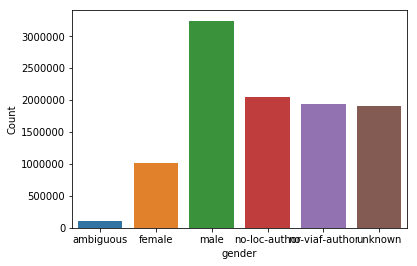

In [26]:
ax = sns.barplot(x="gender", y="Count", data=auth_dist1)

In [27]:
auth_dist_all = pd.DataFrame({'Count':author_overall.groupby(['gender']).book_id.nunique()})
auth_dist_all.reset_index(inplace = True)

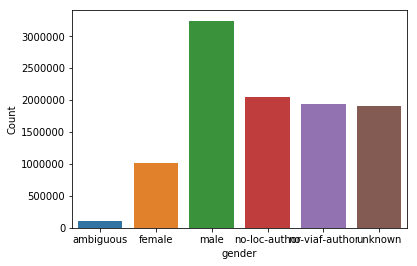

In [28]:
ax = sns.barplot(x="gender", y="Count", data=auth_dist_all)

### Paper: Measuring Fairness in Ranked Outputs

# Fairness Measure

### Female and male only in recommended data

In [29]:
FvsM = author_ranking[(author_ranking['gender'] == "male")| (author_ranking['gender'] == "female")]
#author_ranking.loc[author_ranking['gender'] == 'female', 'protected'] = 'yes'
#author_ranking.loc[author_ranking['gender'] == 'male', 'protected'] = 'no'
FvsM.head()

,book_id,score,user,rank,gender
0,111104800,9.050000,207851,1,female
1,113108658,9.050000,207851,2,female
2,114322708,9.050000,207851,3,male
3,115956930,8.966667,207851,4,male
4,100865789,8.966667,207851,5,male


### female and male only in overall population

In [30]:
FvsM_all = author_overall[(author_overall['gender'] == "male")| (author_overall['gender'] == "female")]
FvsM_all.head()

,book_id,score,user,rank,gender
0,111104800,9.050000,207851.0,1.0,female
1,111104800,10.899378,86051.0,17.0,female
2,111104800,11.811198,64346.0,32.0,female
3,111104800,9.686442,101739.0,8.0,female
4,111104800,9.093522,209657.0,27.0,female


In [40]:
user_list = ratings['user'].unique()

Proportion of female author in recommended list

In [31]:
no_authors_rec = author_ranking.book_id.nunique()
female_authors = author_ranking[(author_ranking['gender'] == "female")].book_id.nunique()
FM_authors = FvsM.book_id.nunique()

In [32]:
pro_percent=round(female_authors*100/no_authors_rec)
pro_percent_FM=round(female_authors*100/FM_authors)
pro_percent, pro_percent_FM

(32, 42)

Proportion of female authors in overall population

In [33]:
no_all_authors = author_overall.book_id.nunique()
all_female_authors = author_overall[(author_overall['gender'] == "female")].book_id.nunique()
all_FM_authors = FvsM_all.book_id.nunique()

In [34]:
pro_percent = round(all_female_authors*100/no_all_authors)
pro_percent_FM = round(all_female_authors*100/all_FM_authors)
pro_percent, pro_percent_FM

(10, 24)

## rND

#### best (most fair) value at 0, and their worst value at 1.

In [35]:
def rND_measure(table, user_ID):
    rank_diff1 = {}
    Z = 100
    user_data =  table[table.user == user_ID]
    rank_protected = user_data.loc[user_data['gender'] == 'female', 'rank']
    #N = user_data['book_id'].nunique()
    logdiff = 0
    N_authors = table.book_id.nunique()
    total_prop = female_authors/N_authors
    #total_prop = FvsAll_prop
    for i in range(10, 110, 10):
        val_list =[]
        ranked_prop = sum(rank_protected <= i)/i
        diff = ranked_prop - total_prop
        rank_diff1[user_ID, i] = abs(diff/np.log2(i))
        logdiff += abs(diff/np.log2(i))
    return (logdiff / Z), rank_diff1

## rKL (Normalized dixcounted KL-divergence)

In [36]:
def rKL_measure(table, user_ID):
    rank_rKL = {}
    Z = 100
    user_data =  table[table.user == user_ID]
    rank_protected = user_data.loc[user_data['gender'] == 'female', 'rank']
    N_authors = table.book_id.nunique()
    QX = female_authors/N_authors
    if(QX == 0 or QX ==1):
        QX = 0.001
    rKL = 0
    for i in range(10, 110, 10):
        PX = sum(rank_protected <= i)/i
        if(PX == 0 or PX ==1):
            PX = 0.001
        DKL1 = PX * (np.log2((PX/ QX)))
        DKL2 = (1-PX) * (np.log2(((1-PX)/ (1-QX))))
        DKL = DKL1 + DKL2
        rank_rKL[user_ID, i] = (DKL/np.log2(i)) 
        rKL += (DKL/np.log2(i))
        
    return rKL/Z, rank_rKL

## rRL ( Normalized discounted ratio (rRD))

In [37]:
def rRD_measure(table, user_ID):
    rank_rRD = {}
    Z = 100
    N_authors = table.book_id.nunique()
    not_female_authors = N_authors - female_authors
    ##user
    user_data =  table[table.user == user_ID]
    rank_protected = user_data.loc[user_data['gender'] == 'female', 'rank']
    logdiff = 0
    frac_total = female_authors/ not_female_authors
    rRD = 0
    for i in range(10, 110, 10):
        pro = sum(rank_protected <= i)
        unpro = i - pro
        if(pro == 0 or unpro ==0):
            ratio = 0
        else:
            ratio = pro/unpro
        rRD1 = abs(frac_total - ratio)
        rank_rRD[user_ID, i] = (rRD1/np.log2(i)) 
        rRD += abs((rRD1/np.log2(i)))
        
    return rRD/Z, rank_rRD

### Fairness Measure for Female vs all per user

In [38]:
def fairness_table(table, matrix_name, matric_func):
    user_fairness= {}
    rank = {}
    for i in user_list:
        user_fairness[i], rank = matric_func(table, i)
    fairness= pd.DataFrame({matrix_name: user_fairness })
    fairness.index.name = 'User'
    return fairness
    

### rND, rKL, rRD on the recommended list for each user

### Female vs all

In [41]:
rND_fvsall = fairness_table(author_ranking, 'rND', rND_measure)
rND_fvsall.head()

,rND
User,
243,0.002210
709,0.001894
2010,0.000471
2084,0.001637
2132,0.005769


In [42]:
avg_rND_all = rND_fvsall.rND.mean()
avg_rND_all

0.0018401184736911414

In [43]:
rKL_fvsall = fairness_table(author_ranking, 'rKL', rKL_measure)
rKL_fvsall.head()

,rKL
User,
243,0.000960
709,0.000910
2010,0.000072
2084,0.000625
2132,0.005399


In [105]:
avg_rKL_all = rKL_fvsall.rKL.mean()
avg_rKL_all

0.0010275645414800367

In [145]:
rRD_fvsall = fairness_table(author_ranking, 'rRD', rRD_measure)
rRD_fvsall.head()

,rRD
User,
243,0.004071
709,0.003475
2010,0.001077
2084,0.003074
2132,0.023228


In [146]:
avg_rRD_all = rRD_fvsall.rRD.mean()
avg_rRD_all

0.004160955339280656

### Female vs Male 

In [87]:
rND_fvsm = fairness_table(FvsM, 'rND', rND_measure)
rND_fvsm.head()

,rND
User,
243,0.404305
709,0.372662
2010,0.172647
2084,0.347042
2132,0.393634


In [88]:
rKL_fvsm = fairness_table(FvsM, 'rKL', rKL_measure)
rKL_fvsm.head()

,rKL
User,
243,0.283093
709,0.259072
2010,0.054954
2084,0.215153
2132,0.246991


In [118]:
rRD_fvsM = fairness_table(FvsM, 'rRD', rRD_measure)
rRD_fvsM.head()

,rRD
User,
243,0.008700
709,0.008104
2010,0.004320
2084,0.007704
2132,0.018599


### rND, rKL, rRD on the overall population for each user

## Fairness  Measure in ranking for Female vs All 


In [131]:
def avg_fairness(data_table, matrix_name, fairness_func):
    rank_diff = {}
    user_fairness = {}
    for i in user_list:
        user_fairness[i], rank_diff = fairness_func(data_table, i)
    ranked_fairness = pd.DataFrame({matrix_name:rank_diff}).reset_index()
    ranked_fairness = ranked_fairness.rename(columns={"level_0" : "user", "level_1":"rank"})
    average_fairness_rank = pd.DataFrame({matrix_name :ranked_fairness.groupby(['rank'])[matrix_name].mean()})
    return average_fairness_rank
    
    

### rND

In [122]:
avg_Fvs_all_rND =  avg_fairness(author_ranking, 'rND', rND_measure)
avg_Fvs_all_rND

,rND
rank,
10,0.084120
20,0.041519
30,0.036569
40,0.038415
50,0.028251
60,0.021914
70,0.015292
80,0.014543
90,0.015660


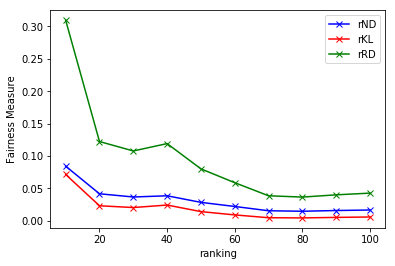

In [139]:
X1 = avg_Fvs_all_rND['rND']
X2 = avg_Fvs_all_rKL['rKL']
X3 = avg_Fvs_all_rRD['rRD']
plt.xlabel('ranking')
plt.ylabel('Fairness Measure')
plt.plot(X1, marker='x', color='blue', label = "rND")
plt.plot(X2 ,marker='x', color='red', label = 'rKL')
plt.plot(X3, marker='x', color='green', label ='rRD')
plt.legend()

### rKL

In [123]:
avg_Fvs_all_rKL =  avg_fairness(author_ranking, 'rKL', rKL_measure)
avg_Fvs_all_rKL

,rKL
rank,
10,0.071310
20,0.023013
30,0.020270
40,0.024119
50,0.013987
60,0.008888
70,0.004547
80,0.004245
90,0.005036


In [130]:
avg_Fvs_all_rRD =  avg_fairness(author_ranking, 'rRD', rRD_measure)
avg_Fvs_all_rRD

,rRD
rank,
10,0.309520
20,0.122215
30,0.107645
40,0.119030
50,0.079960
60,0.058641
70,0.038426
80,0.036434
90,0.039892


## Fairness Measure in ranking for Female vs M

In [141]:
avg_Fvs_M_rND =  avg_fairness(FvsM, 'rND', rND_measure)
avg_Fvs_M_rND

,rND
rank,
10,0.055024
20,0.019155
30,0.016872
40,0.020253
50,0.011125
60,0.005551
70,0.000478
80,0.000746
90,0.000772


In [95]:
avg_Fvs_M_rKL =  avg_fairness(FvsM, 'rKL', rKL_measure)
avg_Fvs_M_rKL

,rKL
rank,
10,0.029296
20,0.004640
30,0.004086
40,0.006372
50,0.002049
60,0.000536
70,0.000004
80,0.000010
90,0.000011


In [132]:
avg_Fvs_M_rRD =  avg_fairness(FvsM, 'rRD', rRD_measure)
avg_Fvs_M_rRD

,rRD
rank,
10,0.236040
20,0.065736
30,0.057900
40,0.073163
50,0.036710
60,0.017317
70,0.001399
80,0.002177
90,0.002292


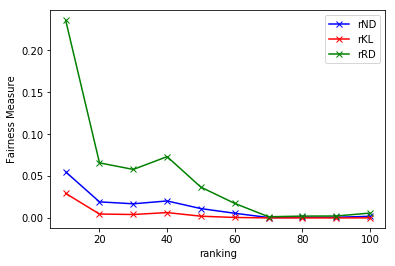

In [142]:
X1 = avg_Fvs_M_rND['rND']
X2 = avg_Fvs_M_rKL['rKL']
X3 = avg_Fvs_M_rRD['rRD']
plt.xlabel('ranking')
plt.ylabel('Fairness Measure')
plt.plot(X1, marker='x', color='blue', label = "rND")
plt.plot(X2 ,marker='x', color='red', label = 'rKL')
plt.plot(X3, marker='x', color='green', label ='rRD')
plt.legend()